In [1]:
import cv2
import torch
import torchvision
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from monai.transforms import (
    apply_transform,
    Randomizable,
    Compose,
    OneOf,
    EnsureChannelFirstDict,
    LoadImageDict,
    SpacingDict,
    OrientationDict,
    DivisiblePadDict,
    CropForegroundDict,
    ResizeDict,
    RandZoomDict,
    ZoomDict,
    RandRotateDict,
    HistogramNormalizeDict,
    ScaleIntensityDict,
    ScaleIntensityRangeDict,
    ToTensorDict,
    Transform
)

In [2]:
import os
import glob
from tqdm.auto import tqdm

In [3]:
def glob_files(folders: str = None, extension: str = "*.nii.gz"):
    assert folders is not None
    paths = [
        glob.glob(os.path.join(folder, extension), recursive=True)
        for folder in folders
    ]
    files = sorted([item for sublist in paths for item in sublist])
    print(len(files))
    print(files[:1])
    return files

In [4]:
ct_folders = [
    "/home/quantm/data/ChestXRLungSegmentation/NSCLC/processed/train/images",
]
ct_images = glob_files(
    ct_folders, 
    extension="*.nii.gz"
)

402
['/home/quantm/data/ChestXRLungSegmentation/NSCLC/processed/train/images/LUNG1-001_0000.nii.gz']


In [5]:
from pytorch3d.renderer.cameras import (
    FoVPerspectiveCameras,
    FoVOrthographicCameras,
    look_at_view_transform,
)

def make_cameras_dea(
    dist: torch.Tensor,
    elev: torch.Tensor,
    azim: torch.Tensor,
    fov: int = 40,
    znear: int = 4.0,
    zfar: int = 8.0,
    is_orthogonal: bool = False,
):
    assert dist.device == elev.device == azim.device
    _device = dist.device
    R, T = look_at_view_transform(dist=dist, elev=elev * 90, azim=azim * 180)
    if is_orthogonal:
        return FoVOrthographicCameras(R=R, T=T, znear=znear, zfar=zfar).to(_device)
    return FoVPerspectiveCameras(R=R, T=T, fov=fov, znear=znear, zfar=zfar).to(_device)


In [6]:
# Define the transformation pipeline for "image2d"
val_transforms = Compose(
    [
        LoadImageDict(keys=["image3d"]),
        EnsureChannelFirstDict(keys=["image3d"],),
        SpacingDict(
            keys=["image3d"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear"],
            align_corners=True,
        ),
        OrientationDict(keys=("image3d"), axcodes="ASL"),
        # ScaleIntensityRangeDict(
        #     keys=["image3d"],
        #     clip=True,
        #     a_min=-1024,
        #     a_max=+3071,
        #     b_min=0.0,
        #     b_max=1.0,
        # ),
        ScaleIntensityRangeDict(
            keys=["image3d"],
            clip=True,
            a_min=-1024,
            a_max=+3071,
            b_min=-1024,
            b_max=+3071,
        ),
        # CropForegroundDict(
        #     keys=["image3d"],
        #     source_key="image3d",
        #     select_fn=(lambda x: x > 0),
        #     margin=0,
        # ),
        # ZoomDict(keys=["image3d"], zoom=0.95, padding_mode="constant", mode=["area"]),
        ResizeDict(
            keys=["image3d"],
            spatial_size=256,
            size_mode="longest",
            mode=["trilinear"],
            align_corners=True,
        ),
        DivisiblePadDict(
            keys=["image3d"],
            k=256,
            mode="constant",
            constant_values=0,
        ),
        ToTensorDict(keys=["image3d"],),
    ]
)

def plot_hist(tensor, bins=4096):
    """
    Plots the histogram of a tensor with values in the range [0, 1).

    Parameters:
    - tensor (torch.Tensor): The input tensor to plot.
    - bins (int): The number of bins for the histogram.
    """
    # Ensure the tensor is in the correct shape
    if tensor.ndim > 1:
        tensor = tensor.view(-1)  # Flatten the tensor

    # Convert to numpy for plotting
    tensor_np = tensor.detach().cpu().numpy()

    # Plotting the histogram
    plt.hist(tensor_np, bins=bins, range=(int(tensor.min()), int(tensor.max())), density=True, alpha=0.7, color='blue')
    plt.title('Histogram of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

def rescaled(x, val=64, eps=1e-8):
    return (x + eps) / (val + eps)

def minimized(x, eps=1e-8):
    return (x + eps) / (x.max() + eps)

def normalized(x, eps=1e-8):
    return (x - x.min() + eps) / (x.max() - x.min() + eps)

def standardized(x, eps=1e-8):
    return (x - x.mean()) / (x.std() + eps)  # 1e-6 to avoid zero division

def transform_hu_to_density(
        volume, 
        bone_attenuation_multiplier=2, 
        # v_min=-800, 
        # v_max=+350, 
        v_min=-800, 
        v_max=+350
    ):
    # volume can be loaded as int16, need to convert to float32 to use float bone_attenuation_multiplier
    volume = volume.to(torch.float32)
    air = torch.where(volume <= v_min)
    soft_tissue = torch.where((v_min < volume) & (volume <= v_max))
    bone = torch.where(v_max < volume)

    density = torch.empty_like(volume)
    density[air] = volume[soft_tissue].min()
    density[soft_tissue] = volume[soft_tissue]
    density[bone] = volume[bone] * bone_attenuation_multiplier
    density = normalized(density)
    return density

In [7]:
# Run forward pass
device = torch.device('cuda:0')
B = 1

fov=12.0
znear=7
zfar=9

In [8]:
dist_hidden = 8 * torch.ones(B, device=device)
elev_hidden = torch.zeros(B, device=device)
azim_hidden = torch.zeros(B, device=device)
view_hidden = make_cameras_dea(
    dist_hidden, 
    elev_hidden, 
    azim_hidden, 
    fov=fov, 
    znear=znear, 
    zfar=zfar,
).to(device)

dist_lateral = 8 * torch.ones(B, device=device)
elev_lateral = torch.zeros(B, device=device)
azim_lateral = torch.ones(B, device=device) * 0.25
view_lateral = make_cameras_dea(
    dist_lateral, 
    elev_lateral, 
    azim_lateral, 
    fov=fov, 
    znear=znear, 
    zfar=zfar,
).to(device)


def correct_window(
    T_old, 
    a_min=-1024, 
    a_max=3071, 
    b_min=-600, #-100, #-512, 
    b_max=800, #+900, #3071, #1536, #2560, 
    factor=1.0    
):
    # Calculate the range for the old and new scales
    range_old = a_max - a_min
    range_new = b_max - b_min

    # Reverse the incorrect scaling
    T_raw = (T_old * range_old) + a_min

    # Apply the correct scaling
    T_new = (T_raw - b_min) / range_new 
    return T_new.clamp(0, 1)


torch.Size([1, 1, 256, 256, 256])
metatensor(3070.8997, device='cuda:0') metatensor(-1024., device='cuda:0')


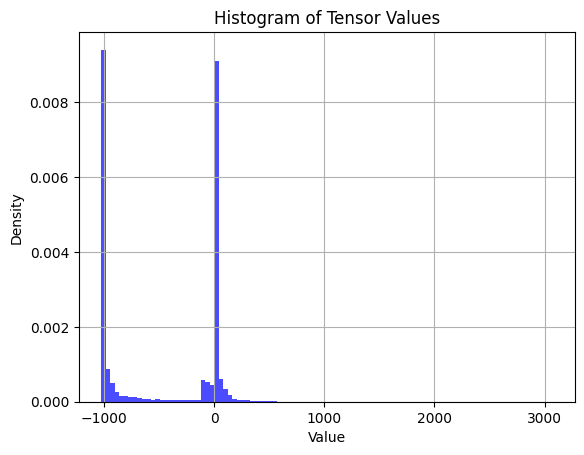

In [9]:
i = 22 #11
data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
print(image3d.shape)
# image3d = correct_window(image3d)
# image3d = transform_hu_to_density(image3d)

#
print(image3d.max(), image3d.min())
plot_hist(image3d.view(-1).clone().detach().cpu(), bins=100)


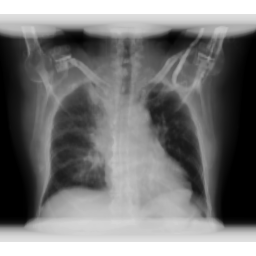

In [10]:

from dvr.renderer import ScreenCentricXRayVolumeRenderer
fwd_renderer = ScreenCentricXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=800,
    min_depth=znear,
    max_depth=zfar,
    ndc_extent=1.0,
)

data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
image3d = transform_hu_to_density(image3d)
# image3d = correct_window(image3d)

output = fwd_renderer.forward(
    image3d=image3d, 
    cameras=view_hidden, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) #.transpose(-1, -2)

torchvision.io.write_png(output, f"ScreenCentricXRayHiddenImage.png")
Image(filename="ScreenCentricXRayHiddenImage.png")

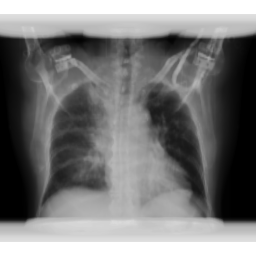

In [ ]:
from dvr.renderer import ObjectCentricXRayVolumeRenderer
fwd_renderer = ObjectCentricXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=800,
    min_depth=znear,
    max_depth=zfar,
    ndc_extent=1.0,
)

data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
image3d = transform_hu_to_density(image3d)
# image3d = correct_window(image3d)

output = fwd_renderer.forward(
    image3d=image3d, 
    cameras=view_hidden, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) #.transpose(-1, -2)

torchvision.io.write_png(output, f"ObjectCentricXRayHiddenImage.png")
Image(filename="ObjectCentricXRayHiddenImage.png")

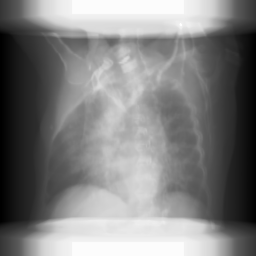

In [ ]:
from dvr.renderer import ObjectCentricXRayVolumeRenderer
fwd_renderer = ObjectCentricXRayVolumeRenderer(
    image_width=256,
    image_height=256,
    n_pts_per_ray=800,
    min_depth=znear,
    max_depth=zfar,
    ndc_extent=1.0,
)

data = {}
data["image3d"] = ct_images[i]
image3d = val_transforms(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
image3d = transform_hu_to_density(image3d)
# image3d = correct_window(image3d)

output = fwd_renderer.forward(
    image3d=image3d, 
    cameras=view_lateral, 
).clamp_(0, 1).squeeze().detach().cpu()
output = (255*output).astype(torch.uint8).unsqueeze(0) #.transpose(-1, -2)

torchvision.io.write_png(output, f"ObjectCentricXRayLateralImage.png")
Image(filename="ObjectCentricXRayLateralImage.png")

In [13]:
# ! diff ObjectCentricXRayImage.png ScreenCentricXRayImage.png

In [14]:
# import matplotlib.pyplot as plt

# plt.imshow(
#     (255*image3d).squeeze()[:,128].astype(torch.uint8).detach().cpu().numpy(), 
#     cmap=plt.cm.gray, 
# )
